# Project ML & DM : Loan Strübi & Aurélie Wasem

## Simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Generation

In [2]:
# =========================================================
# SWISS SYNTHETIC GENERATOR with dependency-aware sampling
# Implements the edges by adjusting categorical logits and numeric means
# Columns:
# ['age','workclass','social-class','education-num','marital-status',
#  'n-children','occupation','race','sex','hours-per-week','native-country','income']
# =========================================================
RNG = np.random.default_rng(2025)

# ---------- Swiss priors ----------
WORKCLASS = ["Private","Self-emp-not-inc","Self-emp-inc","Federal-gov","Local-gov","State-gov","Without-pay","Never-worked"]
OCCUP = ["Tech-support","Craft-repair","Other-service","Sales","Exec-managerial","Prof-specialty",
         "Handlers-cleaners","Machine-op-inspct","Adm-clerical","Farming-fishing","Transport-moving",
         "Priv-house-serv","Protective-serv","Armed-Forces"]
MARITAL = ["Never-married","Married-civ-spouse","Divorced","Separated","Widowed","Married-spouse-absent","Married-AF-spouse"]
RACES = ["White","Black","Asian-Pac-Islander","Latin","Other"]
SEXES = ["Male","Female"]
COUNTRIES = ["Switzerland","Germany","France","Italy"
             ,"Austria","Portugal","Spain","Kosovo","North Macedonia"
             ,"Turkiye","Ukraine","Africa","The Americas","Asia"
             ,"Oceania","Stateless, nationality unknown"]

# Priors (probabilities) calibrated for CH 
p_workclass = np.array([0.732,0.100,0.051,0.020,0.042,0.050,0.003,0.002]); p_workclass/=p_workclass.sum()
p_occ = np.array([0.08,0.08,0.08,0.13,0.13,0.16,0.05,0.06,0.11,0.02,0.05,0.01,0.03,0.01]); p_occ/=p_occ.sum()
p_marital = np.array([0.462,0.398,0.090,0.003,0.045,0.001,0.001]); p_marital/=p_marital.sum()
p_sex = np.array([0.52,0.48])
p_race = np.array([0.6889,0.06,0.09,0.161,0.0001]); p_race/=p_race.sum()
# Countries: CH ~73%, others fill ~27% (weights approximated, renormalized)
p_country = np.array([0.73, 0.27*0.133,0.27*0.07,0.27*0.138
                      ,0.27*0.02,0.27*0.103,0.27*0.04,0.27*0.046,0.27*0.028
                      ,0.27*0.031,0.27*0.027,0.27*0.051,0.27*0.036,0.27*0.084
                      ,0.27*0.002,0.27*0.001,])
p_country[-1] = max(1e-9, 1.0 - p_country[:-1].sum()); p_country/=p_country.sum()

# ---------- Utilities ----------
def _softmax_rows(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits, axis=1, keepdims=True)
    p = np.exp(z)
    p /= p.sum(axis=1, keepdims=True)
    return p

def _draw_categorical_rowwise(prob: np.ndarray) -> np.ndarray:
    # Normalize row-wise and draw an index in [0..k-1].
    prob = prob / prob.sum(axis=1, keepdims=True)
    cum = prob.cumsum(axis=1)
    cum[:, -1] = 1.0
    u = RNG.random(prob.shape[0])
    return (u[:, None] <= cum).argmax(axis=1)

def _base_logits(prob_1d: np.ndarray, n: int) -> np.ndarray:
    """Return an (n, k) matrix of baseline logits from a 1D probability vector."""
    prob_1d = np.asarray(prob_1d, dtype=float)
    eps = 1e-12
    logp = np.log(np.clip(prob_1d, eps, 1.0))
    return np.broadcast_to(logp, (n, prob_1d.shape[0])).astype(float).copy()

def _logit_base_from_prob(prob_1d: np.ndarray) -> np.ndarray:
    # convert 1d prob -> single-row logits
    # avoid log(0)
    eps = 1e-9
    return np.log(np.clip(prob_1d, eps, 1.0))

# ---------- Race from native-country (proxy mapping) ----------
def race_from_country(country, americas_probs=(0.4, 0.1, 0.5)):
    # Very coarse proxy (Switzerland & most Europe -> White; China/India -> Asian; Turkey -> Other, etc.)
    if country in {"Asia"}: 
        return "Asian-Pac-Islander"
    if country in {"Africa"}:
        return "Black"
    if country in {"Spain","Portugal"}: 
        return "Latin"
    if country in {"The Americas"}:
        groups = ["white","Black","Latin"]
        return np.random.choice(groups, p=americas_probs)
    if country in {"Stateless, nationnality unknown"}:
        return "Other"
    # all the Balkan/EU neighbors -> White
    return "White"

# ---------- Social-class given native-country & race ----------
def sample_social_class(n, native_country, race):
    logits = _base_logits(np.array([0.30, 0.55, 0.15]), n)  # [working, middle, upper]

    is_foreign = (native_country != "Switzerland").astype(float)
    logits[:, 0] += 0.25 * is_foreign
    logits[:, 1] += 0.05 * (1 - is_foreign)
    logits[:, 2] -= 0.20 * is_foreign

    is_asian = (race == "Asian-Pac-Islander").astype(float)
    logits[:, 2] += 0.05 * is_asian

    is_black = (race == "Black").astype(float)
    logits[:, 2] += 0.05 * is_black

    is_latin = (race == "Latin").astype(float)
    logits[:, 2] += 0.05 * is_latin

    is_other = (race == "Other").astype(float)
    logits[:, 2] += 0.05 * is_other

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(["working", "middle", "upper"])[idx]

# ---------- Education years given social-class, age, sex, native-country ----------
def sample_education_years(n, social, age, sex, native_country):
    # base expectation by social class
    mu = np.where(social=="working", 12.0, np.where(social=="middle", 14.0, 16.0))
    # age effect: under 25 likely lower completed years
    mu -= np.clip(25 - age, 0, 7) * 0.30
    # sex tiny effect (historically): Female +0.1, Male 0 (very small)
    mu += np.where(sex=="Female", 0.10, 0.00)
    # native-country: if not Switzerland and not EU-15, reduce slightly (-0.2)
    non_ch = (native_country != "Switzerland")
    eu = {"Italy","Germany","France","Portugal","Spain","Austria"}
    mu += np.where(non_ch & ~np.isin(native_country, list(eu)), -0.20, 0.0)
    # noise
    yrs = np.rint(np.clip(RNG.normal(mu, 1.2, size=n), 9, 18)).astype(int)
    return yrs

# ---------- Occupation given education, social-class, native-country, sex ----------
def sample_occupation(n, edu_years, social, native_country, sex):
    logits = _base_logits(p_occ, n)  # (n, len(OCCUP))

    # education effect
    edu_c = (edu_years - 12) / 4.0
    W_edu = np.array([+0.6, -0.1, -0.2, +0.2, +0.7, +0.9, -0.4, -0.2, +0.2, -0.8, -0.2, -0.9, 0.0, -0.1])
    logits += np.outer(edu_c, W_edu)  # (n,14) + (n,14)

    # social-class effect
    W_sc_work = np.array([0.0, +0.3, +0.2, 0.0, -0.3, -0.3, +0.3, +0.2, 0.0, +0.1, +0.2, 0.0, 0.0, 0.0])
    W_sc_up   = np.array([0.0, -0.1, -0.2, 0.0, +0.4, +0.4, -0.2, -0.1, +0.1, -0.1, -0.1, -0.1, 0.0, 0.0])
    logits += (social == "working")[:, None] * W_sc_work
    logits += (social == "upper")[:,   None] * W_sc_up

    # native-country (mild)
    non_ch = (native_country != "Switzerland").astype(float)[:, None]
    logits += non_ch * np.array([0,0,0,0,-0.05,-0.05,0,0,-0.03,0,0,0,0,0])[None, :]

    # sex (small)
    is_f = (sex == "Female")[:, None].astype(float); is_m = 1 - is_f
    logits += is_f * np.array([0, -0.05, +0.20, 0, -0.05, 0, 0, 0, +0.15, 0, 0, +0.10, 0, -0.10])[None, :]
    logits += is_m * np.array([0, +0.15, -0.05, 0, +0.05, 0, +0.15, +0.05, -0.05, 0, +0.15, -0.10, 0, +0.10])[None, :]

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(OCCUP)[idx]

# ---------- Workclass given occupation, social-class, native-country ----------
def sample_workclass(n, occupation, social, native_country):
    logits = _base_logits(p_workclass, n)  # (n, len(WORKCLASS))

    is_exec = (occupation == "Exec-managerial").astype(float)
    is_prof = (occupation == "Prof-specialty").astype(float)
    is_adm  = (occupation == "Adm-clerical").astype(float)
    is_techi = (occupation == "Tech-support").astype(float)

    logits[:, WORKCLASS.index("Self-emp-inc")]     += 0.6 * (is_exec + 0.5 * is_prof)
    logits[:, WORKCLASS.index("Self-emp-not-inc")] += 0.3 * (0.5 * is_exec + 0.3 * is_techi)
    logits[:, WORKCLASS.index("Private")]          += 0.2 * (is_exec + is_prof + is_techi)
    logits[:, WORKCLASS.index("State-gov")]        += 0.2 * (is_prof + is_adm)
    logits[:, WORKCLASS.index("Local-gov")]        += 0.1 * (is_prof + is_adm)
    logits[:, WORKCLASS.index("Federal-gov")]      += 0.05 * (is_prof)

    logits[:, WORKCLASS.index("Self-emp-inc")]     += (social == "upper") * 0.4
    logits[:, WORKCLASS.index("Private")]          += (social == "working") * 0.2

    non_ch = (native_country != "Switzerland")
    logits[:, WORKCLASS.index("State-gov")]        += -0.2 * non_ch
    logits[:, WORKCLASS.index("Local-gov")]        += -0.2 * non_ch
    logits[:, WORKCLASS.index("Federal-gov")]      += -0.1 * non_ch

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(WORKCLASS)[idx]

# ---------- Marital-status given age, social-class, occupation (pass 1) ----------
def sample_marital_pass1(n, age, social, occupation):
    logits = _base_logits(p_marital, n)

    logits[:, MARITAL.index("Married-civ-spouse")] += np.clip((age - 28) / 10, 0, 3) * 0.5
    logits[:, MARITAL.index("Never-married")]      += -np.clip((age - 28) / 8,  0, 4) * 0.6

    logits[:, MARITAL.index("Never-married")]      += (social == "upper") * 0.15
    logits[:, MARITAL.index("Married-civ-spouse")] += (social == "upper") * (-0.10)

    occ = np.array(occupation)
    logits[:, MARITAL.index("Married-civ-spouse")] += np.isin(occ, ["Protective-serv","Armed-Forces"]) * 0.10

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(MARITAL)[idx]

# ---------- n-children given age, marital-status, social-class, native-country ----------
def sample_children(n, age, marital, social, native_country):
    base = np.array([0.58, 0.22, 0.16, 0.03, 0.01], dtype=float)
    logits = _base_logits(base, n)

    logits[:, 1] += np.clip((age - 26) / 8, 0, 3) * 0.4
    logits[:, 2] += np.clip((age - 32) / 8, 0, 3) * 0.45
    logits[:, 3] += np.clip((age - 36) / 8, 0, 3) * 0.30
    logits[:, 4] += np.clip((age - 40) / 8, 0, 3) * 0.20
    logits[:, 0] += -np.clip((age - 26) / 6, 0, 4) * 0.5

    logits[:, 2] += (marital == "Married-civ-spouse") * 0.25
    logits[:, 0] += (marital == "Never-married") * 0.35

    logits[:, 2] += (social == "working") * 0.08 + (social == "upper") * (-0.08)
    logits[:, 3] += (social == "working") * 0.05 + (social == "upper") * (-0.05)

    non_ch = (native_country != "Switzerland")
    logits[:, 2] += non_ch * 0.05
    logits[:, 3] += non_ch * 0.03

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array([0, 1, 2, 3, 4])[idx]

# ---------- Hours/week given age, workclass, social-class, sex, n-children ----------
def sample_hours(n, age, workclass, social, sex, n_children):
    # base around 42h
    mu = np.full(n, 42.0)

    # age: slight hump mid-life, reduce after 58
    mu += 0.06*(age-40) - 0.0015*(age-40)**2

    # workclass: self-employed higher, public slightly lower, without-pay very low, never-worked = 0
    mu += np.isin(workclass, ["Self-emp-not-inc","Self-emp-inc"])*7.4
    mu += np.isin(workclass, ["Federal-gov","Local-gov","State-gov"])*(-1.0)
    mu = np.where(workclass=="Without-pay", 8.0, mu)
    mu = np.where(workclass=="Never-worked", 0.0, mu)

    # social-class: working (+0.5h), upper (+0.5h for exec-like intensity)
    mu += (social=="working")*0.5 + (social=="upper")*0.5

    # sex & children: mothers reduce more than fathers (small average effects)
    is_f = (sex=="Female").astype(float)
    mu -= is_f * (0.9*n_children)
    mu -= (1-is_f) * (0.2*n_children)

    # dispersion and bounds
    hours = RNG.normal(mu, 3.5, size=n)
    hours = np.clip(np.rint(hours), 0, 70).astype(int)
    return hours

# ---------- Marital-status pass 2 (adjust with hours -> marital) ----------
def adjust_marital_with_hours(marital, age, hours):
    n = len(marital)
    # small boost to Married if (hours >= 45 and 28<=age<=55), small boost to Never if hours <= 10 & young
    flip_prob = np.zeros(n)
    flip_to_married = ((hours>=45)&(age>=28)&(age<=55)) & (marital=="Never-married")
    flip_prob[flip_to_married] = 0.06
    flip_to_never = ((hours<=10)&(age<30)) & (marital=="Married-civ-spouse")
    flip_prob[flip_to_never] = 0.03
    draw = RNG.random(n)
    out = marital.copy()
    out[(flip_to_married) & (draw < flip_prob)] = "Married-civ-spouse"
    out[(flip_to_never) & (draw < flip_prob)] = "Never-married"
    return out

# ---------- Income given hours, education, age, sex, occ, workclass, race ----------
OCC_MULT = {
    "Exec-managerial": 1.35, "Prof-specialty": 1.30, "Tech-support": 1.10, "Sales": 1.05,
    "Adm-clerical": 0.95, "Craft-repair": 1.00, "Machine-op-inspct": 0.95, "Transport-moving": 0.95,
    "Other-service": 0.85, "Handlers-cleaners": 0.85, "Farming-fishing": 0.80, "Priv-house-serv": 0.75,
    "Protective-serv": 0.95, "Armed-Forces": 1.00
}
WORKCLASS_MULT = {"Private":1.00,"Self-emp-not-inc":1.04,"Self-emp-inc":1.06,
                  "Federal-gov":0.99,"Local-gov":0.98,"State-gov":0.98,"Without-pay":0.05,"Never-worked":0.00}

def annual_income(hours, edu_years, age, sex, occ, workclass, race):
    base_hr = 28.0
    # education premium: piecewise, up to +20%
    edu_prem = np.clip(0.025*np.maximum(0, edu_years-12), 0, 0.20)
    # age hump
    age_prem = np.clip(-0.0009*(age-45)**2 + 0.18, 0, 0.18)
    # sex penalty (aggregate gap, kept modest)
    sex_adj = np.where(sex=="Female", -0.06, 0.0)
    # occupation & workclass multipliers
    occ_mult = np.vectorize(OCC_MULT.get)(occ)
    wc_mult = np.vectorize(WORKCLASS_MULT.get)(workclass)
    # race effect (kept almost neutral to avoid hard-coded bias)
    race_adj = np.where(race=="Other", -0.01, 0.0)

    hourly = base_hr * (1 + edu_prem + age_prem + sex_adj + race_adj) * occ_mult * wc_mult
    weekly = hourly * np.maximum(0, hours)
    annual = weekly * 52
    noise = RNG.normal(0, 3000, size=len(annual))
    return np.maximum(0, annual + noise).round(0).astype(int)

# ---------- Generator ----------
def generate_dataset(n_samples=5000, seed=2025):
    global RNG
    RNG = np.random.default_rng(seed)

    # 1) Exogenous: native-country, age, sex (sex weakly dependent on country -> keep neutral)
    native_country = RNG.choice(COUNTRIES, size=n_samples, p=p_country)
    age = RNG.integers(18, 65, size=n_samples)
    sex = RNG.choice(SEXES, size=n_samples, p=p_sex)

    # 2) race depends on native-country
    race = np.array([race_from_country(c) for c in native_country])

    # 3) social-class depends on native-country, race
    social = sample_social_class(n_samples, native_country, race)

    # 4) education-num depends on age, social-class, sex, native-country
    edu_years = sample_education_years(n_samples, social, age, sex, native_country)

    # 5) occupation depends on education-num, social-class, native-country, sex
    occupation = sample_occupation(n_samples, edu_years, social, native_country, sex)

    # 6) workclass depends on occupation, social-class, native-country
    workclass = sample_workclass(n_samples, occupation, social, native_country)

    # 7) marital-status (pass 1) depends on age, social-class, occupation
    marital = sample_marital_pass1(n_samples, age, social, occupation)

    # 8) n-children depends on age, marital-status, social-class, native-country
    n_children = sample_children(n_samples, age, marital, social, native_country)

    # 9) hours-per-week depends on age, workclass, social-class, sex, n-children
    hours = sample_hours(n_samples, age, workclass, social, sex, n_children)

    # 10) marital-status (pass 2) tiny adjustment from hours -> marital
    marital = adjust_marital_with_hours(marital, age, hours)

    # 11) income depends on age, workclass, social-class (indirect), education-num, occupation, race, sex, hours
    income = annual_income(hours, edu_years, age, sex, occupation, workclass, race)

    df = pd.DataFrame({
        "age": age,
        "workclass": workclass,
        "social-class": social,
        "education-num": edu_years,
        "marital-status": marital,
        "n-children": n_children,
        "occupation": occupation,
        "race": race,
        "sex": sex,
        "hours-per-week": hours,
        "native-country": native_country,
        "income": income
    })
    return df

### Encodiong categorical variables

In [3]:
# =========================================================
# Encode all variables to numeric + keep name->code mappings
# =========================================================
import pandas as pd
import numpy as np

# Reuse the vocabularies defined earlier (fallbacks if not present)
SOCIAL = ["working","middle","upper"]
try:
    WORKCLASS
except NameError:
    WORKCLASS = ["Private","Self-emp-not-inc","Self-emp-inc","Federal-gov","Local-gov","State-gov","Without-pay","Never-worked"]
try:
    OCCUP
except NameError:
    OCCUP = ["Tech-support","Craft-repair","Other-service","Sales","Exec-managerial","Prof-specialty",
             "Handlers-cleaners","Machine-op-inspct","Adm-clerical","Farming-fishing","Transport-moving",
             "Priv-house-serv","Protective-serv","Armed-Forces"]
try:
    MARITAL
except NameError:
    MARITAL = ["Never-married","Married-civ-spouse","Divorced","Separated","Widowed","Married-spouse-absent","Married-AF-spouse"]
try:
    RACES
except NameError:
    RACES = ["White","Black","Asian-Pac-Islander","Latin","Other"]
try:
    SEXES
except NameError:
    SEXES = ["Male","Female"]
try:
    COUNTRIES
except NameError:
    COUNTRIES = ["Switzerland","Germany","France","Italy"
             ,"Austria","Portugal","Spain","Kosovo","North Macedonia"
             ,"Turkiye","Ukraine","Africa","The Americas","Asia"
             ,"Oceania","Stateless, nationality unknown"]

CATEGORICALS = {
    "workclass": WORKCLASS,
    "social-class": SOCIAL,
    "marital-status": MARITAL,
    "occupation": OCCUP,
    "race": RACES,
    "sex": SEXES,
    "native-country": COUNTRIES,
}
NUMERICS = ["age","education-num","n-children","hours-per-week","income"]

def encode_all_numeric(df: pd.DataFrame):
    df = df.copy()
    codebooks = {}
    # Build numeric codes for each categorical using a fixed vocabulary/order
    for col, vocab in CATEGORICALS.items():
        cat = pd.Categorical(df[col], categories=vocab, ordered=True)
        codes = cat.codes.astype(int)  # 0..K-1; -1 means "not found"
        # Save codebook (code -> label)
        codebooks[col] = pd.DataFrame({"code": range(len(vocab)), "label": vocab})
        # Replace in df with numeric
        df[col] = codes

    # Ensure numeric dtypes on the rest
    for col in NUMERICS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Optional: also build a human-readable version with *_id + *_label pairs
    df_with_labels = df.copy()
    for col, vocab in CATEGORICALS.items():
        # keep numeric id in <col>_id and add explicit label column next to it
        df_with_labels.insert(df_with_labels.columns.get_loc(col)+1, f"{col}_label",
                              pd.Categorical.from_codes(df[col], categories=vocab).astype(str))
        df_with_labels.rename(columns={col: f"{col}_id"}, inplace=True)

    # Final numeric-only dataframe
    df_num = df[NUMERICS + list(CATEGORICALS.keys())].copy()
    df_num = df_num.astype({c:"int32" for c in df_num.columns if c != "income"})
    df_num["income"] = df_num["income"].astype("int64")

    return df_num, codebooks, df_with_labels



### Example of generated dataset

In [35]:
large_dataset_cat = generate_dataset(n_samples=10000)
large_dataset, codebooks, df_Large_num_with_labels = encode_all_numeric(large_dataset_cat)

In [36]:
large_dataset.head()

,age,education-num,n-children,hours-per-week,income,workclass,social-class,marital-status,occupation,race,sex,native-country
0,34,11,0,46,63132,0,0,2,6,0,0,15
1,20,10,0,42,75919,0,1,0,4,0,1,0
2,23,15,0,41,81168,0,2,0,4,0,1,4
3,38,11,0,48,86631,1,1,1,3,3,0,5
4,45,13,1,37,66620,0,1,1,3,0,1,15


#### With label for better human readability

In [37]:
df_Large_num_with_labels.head()

,age,workclass_id,workclass_label,social-class_id,social-class_label,education-num,marital-status_id,marital-status_label,n-children,occupation_id,occupation_label,race_id,race_label,sex_id,sex_label,hours-per-week,native-country_id,native-country_label,income
0,34,0,Private,0,working,11,2,Divorced,0,6,Handlers-cleaners,0,White,0,Male,46,15,"Stateless, nationality unknown",63132
1,20,0,Private,1,middle,10,0,Never-married,0,4,Exec-managerial,0,White,1,Female,42,0,Switzerland,75919
2,23,0,Private,2,upper,15,0,Never-married,0,4,Exec-managerial,0,White,1,Female,41,4,Austria,81168
3,38,1,Self-emp-not-inc,1,middle,11,1,Married-civ-spouse,0,3,Sales,3,Latin,0,Male,48,5,Portugal,86631
4,45,0,Private,1,middle,13,1,Married-civ-spouse,1,3,Sales,0,White,1,Female,37,15,"Stateless, nationality unknown",66620


### Plots

#### Correlation Matrix

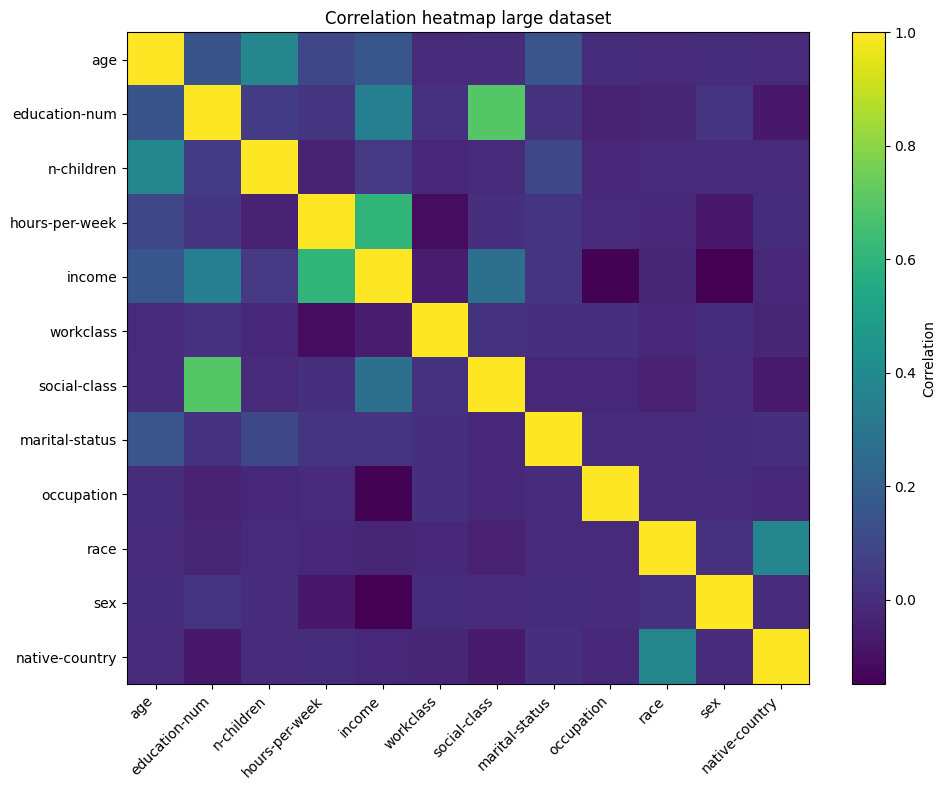

In [38]:
# Correlation between all columns
num_cols = large_dataset.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
corr = large_dataset[num_cols].corr()

# 2) Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar(label='Correlation')
plt.title('Correlation heatmap large dataset')
plt.tight_layout()
plt.show()

#### Barplots

Top correlated variables :
hours-per-week    0.601094
education-num     0.347781
social-class      0.273332
age               0.159172
Name: income, dtype: float64


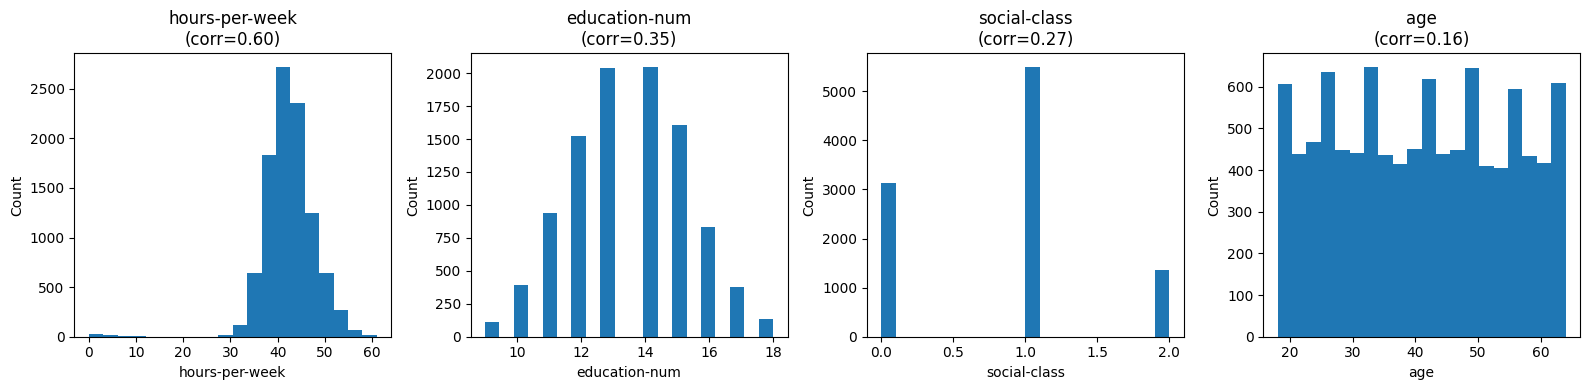

In [39]:
# 1) Numerical columns
num_cols = large_dataset.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns

# 2) Correlation with target variable
corr = large_dataset[num_cols].corr()
corr_income = corr["income"].drop("income")

# 3) Top k correlated variables with income
k = 4
top_vars = corr_income.abs().sort_values(ascending=False).head(k).index
print("Top correlated variables :")
print(corr_income[top_vars])

# 4) Plots of distributions
fig, axes = plt.subplots(1, len(top_vars), figsize=(4*len(top_vars), 4))

if len(top_vars) == 1:
    axes = [axes]  
for ax, col in zip(axes, top_vars):
    ax.hist(large_dataset[col], bins=20)
    ax.set_title(f"{col}\n(corr={corr_income[col]:.2f})")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


## Main Pipeline

### importing the dataset

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/adult-census-income")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\loans\.cache\kagglehub\datasets\uciml\adult-census-income\versions\3


In [10]:
import os
import pandas as pd

print(os.listdir(path))

['adult.csv']


## Dataset collection

In [11]:
file_path = os.path.join(path, "adult.csv")  # adjust name if needed
df = pd.read_csv(file_path)

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Remove unuse columns

In [12]:
df = df.drop(columns=['education','fnlwgt'], axis=1)

df.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [13]:
# Replace "?" with NaN values
df.replace("?", np.nan, inplace = True)
df.head(5)

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Replace undefined value

In [14]:
# Check for missing data
miss_data = df.isnull()
miss_data.sum()

age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [15]:
miss_col = []
for column in miss_data.columns.values.tolist():
    if(miss_data[column].sum() > 0):
        print("Column: ",column)
        print("Missing Data: {} ({:.2f}%)".format(miss_data[column].sum(), (miss_data[column].sum() * 100/ len(df))))
        print("")
        miss_col.append(column)

Column:  workclass
Missing Data: 1836 (5.64%)

Column:  occupation
Missing Data: 1843 (5.66%)

Column:  native.country
Missing Data: 583 (1.79%)



In [16]:
def fill_with_conditional_mode(df, target_col, condition_cols):
    """
    Fill NaNs in `target_col` using the most frequent value among rows
    that share the same values in `condition_cols`.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe (modified in-place).
    target_col : str
        Column to impute (categorical).
    condition_cols : list[str]
        Columns used to define "similar" rows.

    Returns
    -------
    pd.DataFrame
        The same dataframe, for convenience.
    """
    # Global mode as final fallback
    global_mode = df[target_col].mode().iloc[0]

    missing_mask = df[target_col].isna()

    for idx, row in df[missing_mask].iterrows():
        # Start with all rows as candidates
        candidates_mask = pd.Series(True, index=df.index)

        # Keep only rows that match this row on all condition columns
        for c in condition_cols:
            val = row[c]
            if pd.notna(val):
                candidates_mask &= (df[c] == val)

        # Keep only rows where target_col is not missing
        candidates = df.loc[candidates_mask & df[target_col].notna(), target_col]

        if len(candidates) > 0:
            # Conditional mode
            df.at[idx, target_col] = candidates.mode().iloc[0]
        else:
            # Fallback: global mode of the column
            df.at[idx, target_col] = global_mode

    return df

In [17]:
# Impute 'workclass' en se basant sur le profil socio-démographique + occupation
df = fill_with_conditional_mode(
    df,
    target_col="workclass",
    condition_cols=[
        "education.num", "marital.status",
        "occupation", "relationship", "race", "sex", "income"
    ],
)

# Impute 'occupation' en se basant sur workclass + profil socio-démographique
df = fill_with_conditional_mode(
    df,
    target_col="occupation",
    condition_cols=[
        "education.num", "marital.status",
        "workclass", "relationship", "race", "sex", "income"
    ],
)

# Impute 'native.country' en se basant surtout sur race/sex/income
df = fill_with_conditional_mode(
    df,
    target_col="native.country",
    condition_cols=[
        "race", "sex", "income", "education.num", "marital.status"
    ],
)


In [18]:
miss_data = df.isnull()
miss_data.sum()

age               0
workclass         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

## Outliers

### Visulaisation

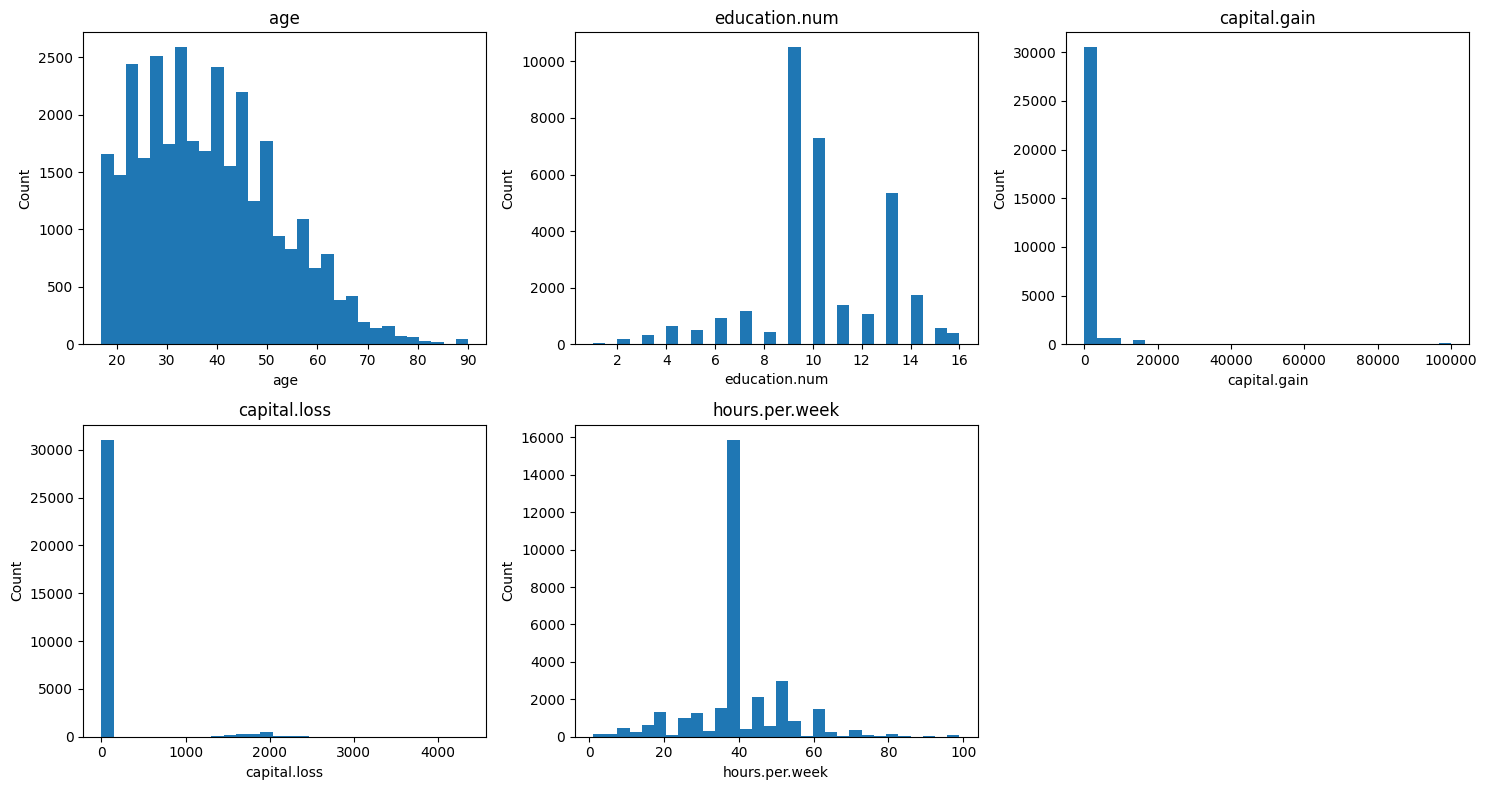

In [19]:
import matplotlib.pyplot as plt

# Numeric variables to inspect
num_vars = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

n = len(num_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# If there are unused subplots, hide them
for i in range(len(num_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


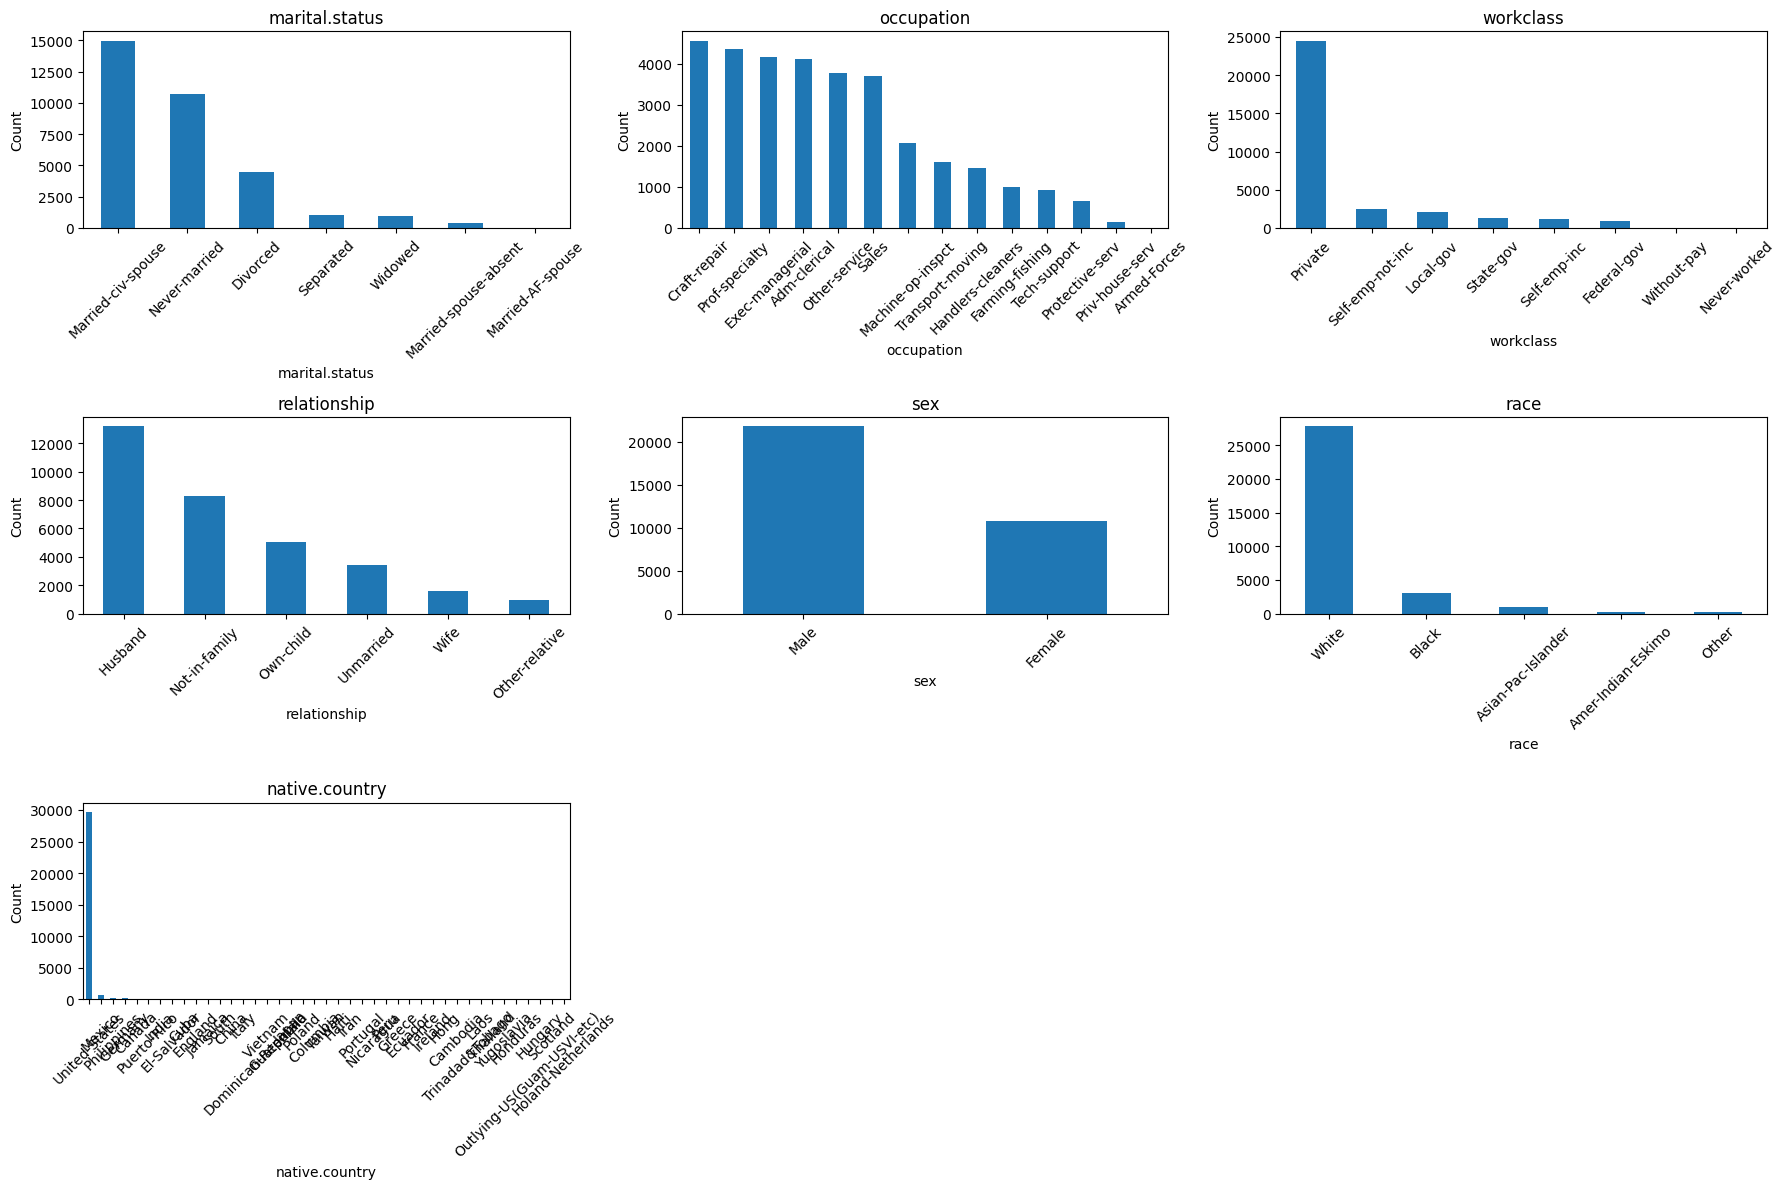

In [20]:
cat_vars = [
    "marital.status",
    "occupation",
    "workclass",
    "relationship",
    "sex",
    "race",
    "native.country",
]

n = len(cat_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_vars):
    counts = df[col].value_counts().sort_values(ascending=False)
    counts.plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", labelrotation=45)

for i in range(len(cat_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


### Detection

In [21]:
num_subset = df.select_dtypes(include=['int64', 'float64'])
print(num_subset.describe())

                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


In [22]:
num_subset = df.select_dtypes(include=["int64", "float64"])

for col in num_subset.columns:
    q1, q3 = num_subset[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0:
        print(f"{col}: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)")
        continue

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_low  = (num_subset[col] < lower).sum()
    n_high = (num_subset[col] > upper).sum()
    print(f"{col}: [{lower:.2f}, {upper:.2f}] → {n_low} low, {n_high} high")


age: [-2.00, 78.00] → 0 low, 143 high
education.num: [4.50, 16.50] → 1198 low, 0 high
capital.gain: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)
capital.loss: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)
hours.per.week: [32.50, 52.50] → 5516 low, 3492 high


## Model Choice

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# ---------- 1) Define X and y properly (classification) ----------

# X = all features except income
X = df.drop(columns=["income"])

# y = income, converted to 0/1 (<=50K -> 0, >50K -> 1)
y_raw = df["income"]
y = (y_raw.astype(str).str.strip() == ">50K").astype(int)

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True, dtype=float)

# Train / test split (stratified for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ---------- 2) Bootstrap on ACCURACY (not MSE) ----------

def bootstrap_accuracy(model, X, y, n_bootstrap=20, random_state=42):
    """
    Estimate accuracy confidence interval via bootstrap.

    Parameters
    ----------
    model : sklearn classifier
        Any sklearn-style classifier with fit / predict methods.
    X : np.ndarray
        Feature matrix (n_samples, n_features).
    y : np.ndarray
        Binary target (0/1) for income.
    n_bootstrap : int
        Number of bootstrap resamples.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    np.ndarray
        Percentiles [2.5, 97.5] of bootstrap accuracies.
    """
    rng = np.random.RandomState(random_state)
    metrics = []

    for _ in range(n_bootstrap):
        indices = rng.choice(len(X), len(X), replace=True)
        X_sample = X[indices]
        y_sample = y[indices]

        model.fit(X_sample, y_sample)
        y_pred = model.predict(X_sample)
        metrics.append(accuracy_score(y_sample, y_pred))

    return np.percentile(metrics, [2.5, 97.5])

# ---------- 3) Classification models only ----------

models = {
    # k-Nearest Neighbors classifier
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",     # or "distance"
        metric="minkowski"     # Euclidean distance by default
    ),

    "Linear SVM": LinearSVC(
        C=1.0,
        random_state=42
    ),

    # Naive Bayes classifier (Gaussian)
    "Naive Bayes": GaussianNB(),

    # Random Forest classifier
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),

    # Decision Tree classifier
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ),
    
    # Gradient Boosting classifier
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),  

    # AdaBoost classifier
    "AdaBoost": AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),
}

# ---------- 4) Evaluation loop (no MSE / R2 anymore) ----------

results = []

for name, model in models.items():
    # Fit on train
    model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)

    # Accuracy & F1
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC (if we have a score/proba)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
    else:
        auc = np.nan

    # Cross-validation accuracy on the full dataset
    cv_scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    cv_mean = cv_scores.mean()

    # Bootstrap CI on accuracy (train set)
    ci = bootstrap_accuracy(model, X_train.values, y_train.values)

    results.append(
        {
            "Model": name,
            "Test_Accuracy": np.round(acc, 3),
            "Test_F1": np.round(f1, 3),
            "ROC_AUC": np.round(auc, 3) if not np.isnan(auc) else np.nan,
            "CV_Accuracy": np.round(cv_mean, 3),
            "Acc_CI_2.5": np.round(ci[0], 3),
            "Acc_CI_97.5": np.round(ci[1], 3),
        }
    )

results_df = pd.DataFrame(results)
results_df

C:\Users\loans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\loans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\loans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

,Model,Test_Accuracy,Test_F1,ROC_AUC,CV_Accuracy,Acc_CI_2.5,Acc_CI_97.5
0,KNN,0.840,0.666,0.869,0.780,0.918,0.923
1,Linear SVM,0.852,0.660,0.900,0.821,0.846,0.854
2,Naive Bayes,0.820,0.670,0.886,0.810,0.815,0.828
3,Random Forest,0.846,0.658,0.894,0.800,0.984,0.986
4,Decision Tree,0.823,0.624,0.769,0.766,0.984,0.986
5,Gradient Boosting,0.861,0.675,0.916,0.810,0.868,0.876
6,AdaBoost,0.851,0.631,0.902,0.807,0.853,0.857


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

# -------- 1) Features / target --------
X = pd.get_dummies(df.drop(columns=["income"]), drop_first=True, dtype=float)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42, stratify=y
)

# -------- 2) Model: Gradient Boosting --------
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
)
model.fit(X_train, y_train)

# =====================================================
# A. IMPURITY-BASED IMPORTANCE (par feature dummy)
# =====================================================
# Importance for each dummy / numeric column
feat_imp = pd.Series(model.feature_importances_, index=model.feature_names_in_)

impurity_df = (
    feat_imp
    .reset_index()
    .rename(columns={"index": "Feature", 0: "Importance"})
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

print("Top features (dummy-level):")
display(impurity_df.head(20))


# =====================================================
# B. IMPURITY-BASED IMPORTANCE (regroupée par variable d'origine)
#    e.g. 'workclass_Private' -> 'workclass'
# =====================================================

def original_var_name(col: str) -> str:
    """
    Extract original variable name from a dummy feature name.
    Example:
        'workclass_Private' -> 'workclass'
        'education_Bachelors' -> 'education'
        'age' -> 'age'  (no underscore)
    """
    return col.split("_")[0]

impurity_by_var = (
    feat_imp
    .groupby(original_var_name)   # group all dummies with same prefix
    .sum()
    .sort_values(ascending=False)
    .rename_axis("Variable")
    .reset_index(name="Importance")
)

print("Importance aggregated by original variable:")
display(impurity_by_var)


# =====================================================
# C. (OPTIONNEL) PERMUTATION IMPORTANCE regrouppée
# =====================================================

perm = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="accuracy",
)

perm_series = pd.Series(perm.importances_mean, index=X.columns)

perm_by_var = (
    perm_series
    .groupby(original_var_name)
    .sum()
    .sort_values(ascending=False)
    .rename_axis("Variable")
    .reset_index(name="Perm_Importance")
)

print("Permutation importance aggregated by original variable:")
display(perm_by_var)


Top features (dummy-level):


,Feature,Importance
0,marital.status_Married-civ-spouse,0.383033
1,education.num,0.198727
2,capital.gain,0.197803
3,age,0.064329
4,capital.loss,0.060901
5,hours.per.week,0.038179
6,occupation_Exec-managerial,0.017888
7,occupation_Prof-specialty,0.007210
8,occupation_Other-service,0.006052
9,occupation_Farming-fishing,0.005414


Importance aggregated by original variable:


,Variable,Importance
0,marital.status,0.383938
1,education.num,0.198727
2,capital.gain,0.197803
3,age,0.064329
4,capital.loss,0.060901
5,occupation,0.041437
6,hours.per.week,0.038179
7,relationship,0.006697
8,workclass,0.003846
9,sex,0.002040


Permutation importance aggregated by original variable:


,Variable,Perm_Importance
0,marital.status,0.043525
1,capital.gain,0.042543
2,education.num,0.031068
3,age,0.015938
4,capital.loss,0.011844
5,occupation,0.007688
6,hours.per.week,0.006930
7,relationship,0.002037
8,workclass,0.001587
9,sex,0.000512


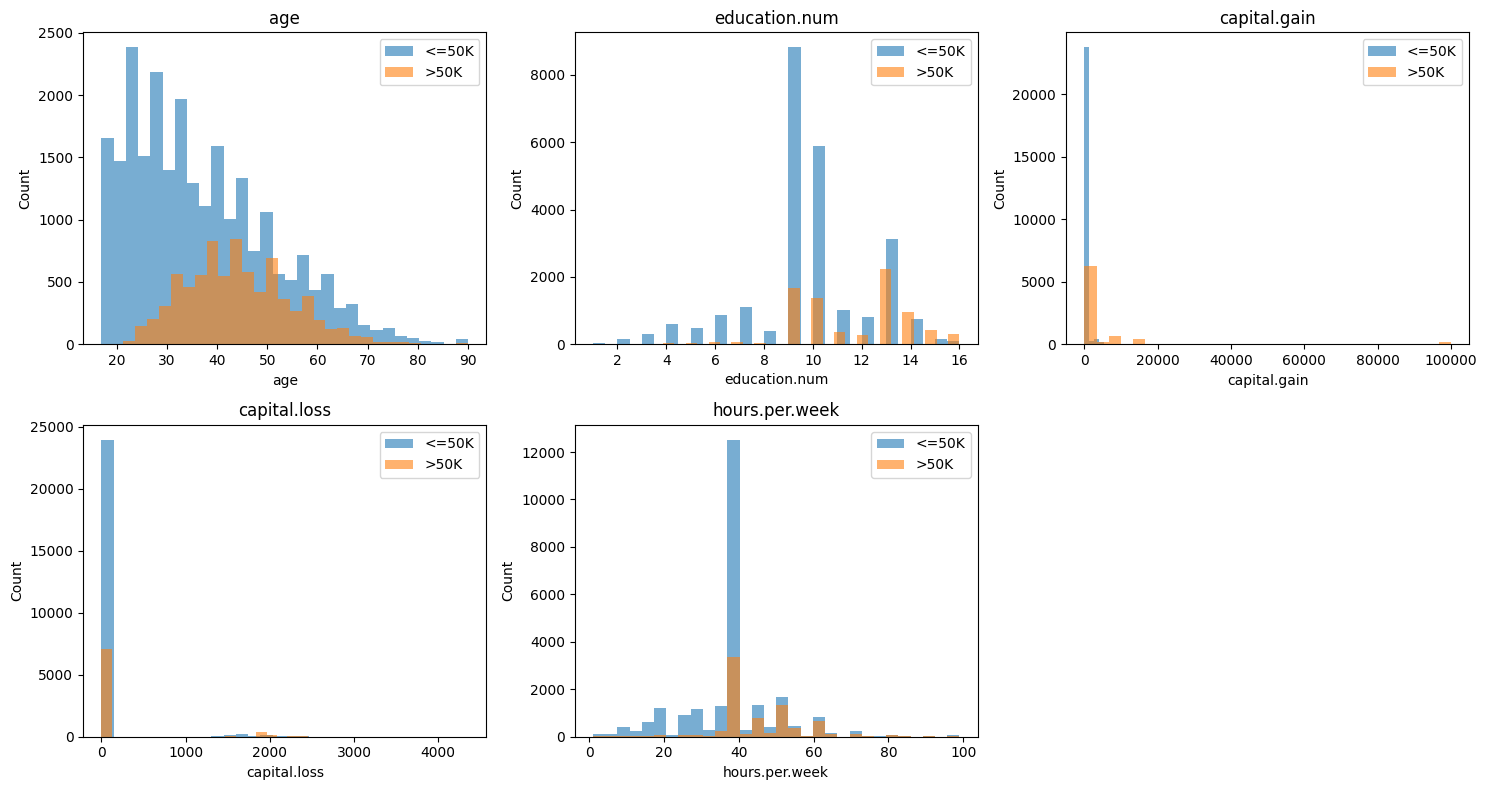

In [ ]:

# Clean income labels just in case there are spaces
income_clean = df["income"].astype(str).str.strip()
mask_high = income_clean == ">50K"
mask_low = income_clean == "<=50K"

num_vars = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

n = len(num_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    # Low income
    ax.hist(df.loc[mask_low, col].dropna(), bins=30, alpha=0.6, label="<=50K")
    # High income
    ax.hist(df.loc[mask_high, col].dropna(), bins=30, alpha=0.6, label=">50K")
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend()

for i in range(len(num_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:

from scipy.stats import chi2_contingency

def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    Compute Cramér's V for two categorical variables.
    
    Parameters
    ----------
    x : pd.Series
        First categorical variable.
    y : pd.Series
        Second categorical variable.
    
    Returns
    -------
    float
        Association in [0, 1].
    """
    table = pd.crosstab(x, y)
    if table.size == 0:
        return np.nan
    
    chi2, p, dof, expected = chi2_contingency(table)
    n = table.values.sum()
    if n == 0:
        return np.nan
    
    r, k = table.shape
    if min(r, k) <= 1:
        return 0.0
    
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


def correlation_ratio(categories: pd.Series, values: pd.Series) -> float:
    """
    Compute correlation ratio (eta) for a categorical and a numerical variable.
    
    Parameters
    ----------
    categories : pd.Series
        Categorical variable.
    values : pd.Series
        Numerical variable.
    
    Returns
    -------
    float
        Correlation ratio in [0, 1].
    """
    # Drop missing
    mask = (~pd.isna(categories)) & (~pd.isna(values))
    cat = pd.Categorical(categories[mask])
    y = values[mask].astype(float).values
    
    if y.size == 0:
        return np.nan
    
    overall_mean = y.mean()
    ss_between = 0.0
    ss_total = ((y - overall_mean) ** 2).sum()
    
    for level in np.unique(cat):
        level_mask = (cat == level)
        y_level = y[level_mask]
        if y_level.size == 0:
            continue
        ss_between += y_level.size * (y_level.mean() - overall_mean) ** 2
    
    if ss_total == 0:
        return 0.0
    
    eta_squared = ss_between / ss_total
    eta = np.sqrt(eta_squared)
    return float(eta)


In [27]:
def mixed_assoc_matrix(df: pd.DataFrame, cols=None) -> pd.DataFrame:
    """
    Compute a mixed-type association matrix for the given columns.
    
    - numeric-numeric: Pearson correlation ([-1, 1])
    - cat-cat: Cramér's V ([0, 1])
    - numeric-cat: correlation ratio eta ([0, 1])
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cols : list of str, optional
        Columns to include. If None, all columns are used.
    
    Returns
    -------
    pd.DataFrame
        Square matrix of associations.
    """
    if cols is None:
        cols = list(df.columns)
    else:
        cols = list(cols)
    
    assoc = pd.DataFrame(np.nan, index=cols, columns=cols)
    
    numeric_cols = df[cols].select_dtypes(include="number").columns.tolist()
    cat_cols = [c for c in cols if c not in numeric_cols]
    
    for i, col_i in enumerate(cols):
        for j, col_j in enumerate(cols):
            if j < i:
                continue  # already computed (symmetry)
            
            s_i = df[col_i]
            s_j = df[col_j]
            mask = (~s_i.isna()) & (~s_j.isna())
            s_i2 = s_i[mask]
            s_j2 = s_j[mask]
            
            if s_i2.empty:
                value = np.nan
            elif (col_i in numeric_cols) and (col_j in numeric_cols):
                # numeric-numeric
                value = s_i2.astype(float).corr(s_j2.astype(float))
            elif (col_i in cat_cols) and (col_j in cat_cols):
                # cat-cat
                value = cramers_v(s_i2, s_j2)
            else:
                # mixed: numeric-cat
                if col_i in numeric_cols:
                    num = s_i2
                    cat = s_j2
                else:
                    num = s_j2
                    cat = s_i2
                value = correlation_ratio(cat, num)
            
            assoc.loc[col_i, col_j] = value
            assoc.loc[col_j, col_i] = value
    
    return assoc


In [28]:
cols = [
    "age", "workclass", "education.num", "marital.status",
    "occupation", "relationship", "race", "sex",
    "capital.gain", "capital.loss", "hours.per.week",
    "native.country", "income"
]

assoc = mixed_assoc_matrix(df, cols=cols)

print("Mixed-type association matrix:")
print(assoc.round(3))


Mixed-type association matrix:
                  age  workclass  education.num  marital.status  occupation  \
age             1.000      0.208          0.037           0.574       0.218   
workclass       0.208      1.000          0.190           0.078       0.199   
education.num   0.037      0.190          1.000           0.115       0.568   
marital.status  0.574      0.078          0.115           1.000       0.140   
occupation      0.218      0.199          0.568           0.140       1.000   
relationship    0.474      0.091          0.161           0.488       0.192   
race            0.044      0.055          0.110           0.084       0.084   
sex             0.089      0.143          0.012           0.462       0.452   
capital.gain    0.078      0.104          0.123           0.087       0.119   
capital.loss    0.058      0.046          0.080           0.082       0.084   
hours.per.week  0.069      0.168          0.148           0.251       0.274   
native.country  0.087

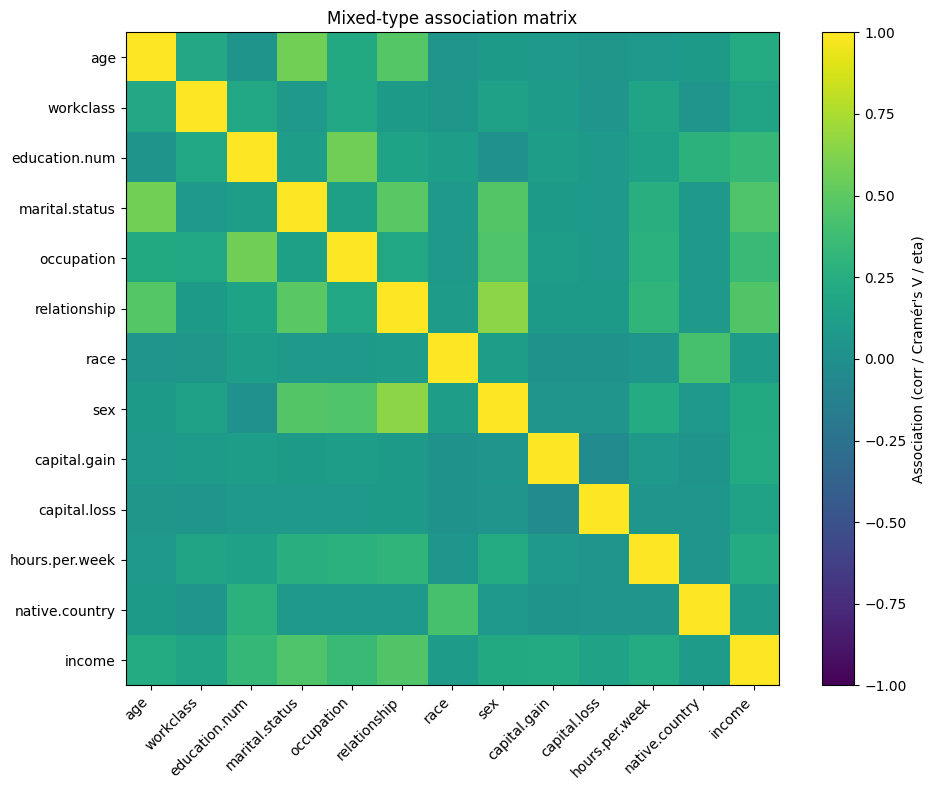

In [ ]:

plt.figure(figsize=(10, 8))
im = plt.imshow(assoc, vmin=-1, vmax=1)
plt.colorbar(im, label="Association (corr / Cramér's V / eta)")

plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Mixed-type association matrix")
plt.tight_layout()
plt.show()


In [30]:
levels = {
    "native.country": 0,
    "race": 0,
    "sex": 0,
    "age": 1,
    "education.num": 2,
    "workclass": 3,
    "marital.status": 3,
    "occupation": 4,
    "relationship": 5,
    "hours.per.week": 6,
    "capital.gain": 6,
    "capital.loss": 6,
    "income": 7,
}


In [31]:
threshold = 0.1  # on garde >0.5 ou <-0.5

strong_edges = []

for i, col_i in enumerate(cols):
    for j in range(i + 1, len(cols)):
        col_j = cols[j]
        val = assoc.loc[col_i, col_j]
        if pd.notna(val) and abs(val) >= threshold:
            # Orienter selon l'ordre "causal"
            li = levels[col_i]
            lj = levels[col_j]
            if li < lj:
                strong_edges.append((col_i, col_j, val))
            elif lj < li:
                strong_edges.append((col_j, col_i, val))
            else:
                # même niveau -> soit on ignore, soit on décide à la main
                # ici on ignore pour garder un DAG propre
                pass

print("Arêtes fortes du DAG (source -> cible, association):")
for u, v, w in sorted(strong_edges, key=lambda t: abs(t[2]), reverse=True):
    print(f"{u:15s} -> {v:15s}  (assoc = {w:.3f})")


Arêtes fortes du DAG (source -> cible, association):
sex             -> relationship     (assoc = 0.649)
age             -> marital.status   (assoc = 0.574)
education.num   -> occupation       (assoc = 0.568)
marital.status  -> relationship     (assoc = 0.488)
age             -> relationship     (assoc = 0.474)
sex             -> marital.status   (assoc = 0.462)
relationship    -> income           (assoc = 0.454)
sex             -> occupation       (assoc = 0.452)
marital.status  -> income           (assoc = 0.447)
occupation      -> income           (assoc = 0.354)
education.num   -> income           (assoc = 0.335)
relationship    -> hours.per.week   (assoc = 0.310)
native.country  -> education.num    (assoc = 0.283)
occupation      -> hours.per.week   (assoc = 0.274)
marital.status  -> hours.per.week   (assoc = 0.251)
age             -> income           (assoc = 0.234)
hours.per.week  -> income           (assoc = 0.230)
sex             -> hours.per.week   (assoc = 0.229)
capital.gai

C:\Users\loans\AppData\Local\Temp\ipykernel_13608\1700400790.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


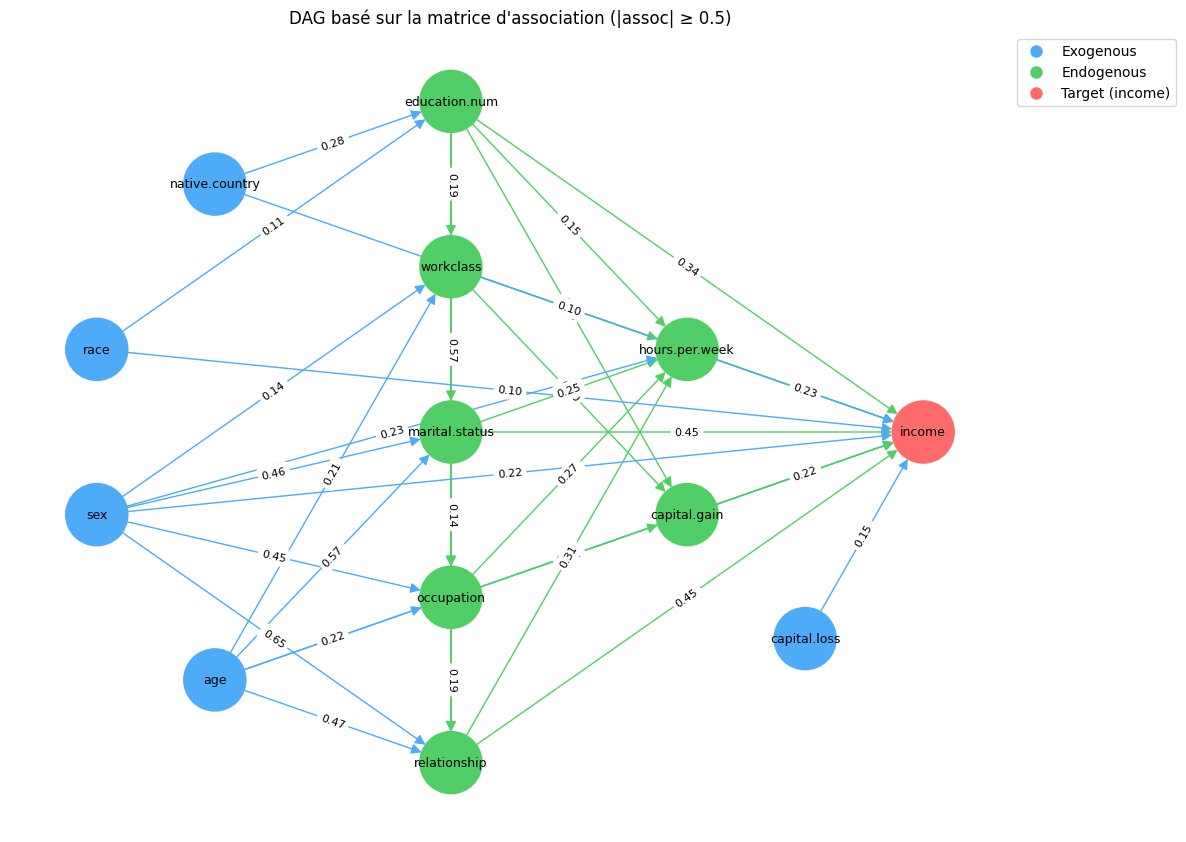

In [ ]:
import networkx as nx
from matplotlib.lines import Line2D

# === 1. Build the graph as before ==========================================
G = nx.DiGraph()
G.add_nodes_from(cols)
for u, v, w in strong_edges:
    G.add_edge(u, v, weight=w)

# === 2. Positions (your manual layout) =====================================
pos = {
     "native.country": (-4,  3),
     "race":           (-4.5,  2),
     "sex":            ( -4.5,  1),
     "age":            ( -4,  0),
     "education.num":  (-3,  3.5),
     "workclass":      (-3,  2.5),
     "marital.status": ( -3,  1.5),
     "occupation":     ( -3,  0.5),
     "relationship":   ( -3,  -0.5),
     "hours.per.week": (-2, 2),
     "capital.gain":   ( -2, 1),
     "capital.loss":   ( -1.5, 0.25),
     "income":         (-1, 1.5),
 }

# === 3. Classify nodes: exogenous / endogenous / target ====================
target_var = "income"

exogenous_nodes = [n for n in G.nodes if G.in_degree(n) == 0 and n != target_var]

endogenous_nodes = [
    n for n in G.nodes
    if n not in exogenous_nodes and n != target_var
]

# Build node colors (same as before)
node_colors = []
for n in G.nodes:
    if n == target_var:
        node_colors.append("#ff6b6b")   # target = red-ish
    elif n in exogenous_nodes:
        node_colors.append("#4dabf7")   # exogenous = blue-ish
    else:
        node_colors.append("#51cf66")   # endogenous = green-ish

# === NEW: Build edge colors based on the SOURCE node =======================
edges = list(G.edges())   # fixed order for edges

edge_colors = []
for u, v in edges:
    if u == target_var:
        edge_colors.append("#ff6b6b")   # edge coming from target
    elif u in exogenous_nodes:
        edge_colors.append("#4dabf7")   # edge coming from exogenous
    else:
        edge_colors.append("#51cf66")   # edge coming from endogenous

# === 4. Draw the DAG =======================================================
plt.figure(figsize=(10, 8))

nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=2000,
    font_size=9,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=15,
    edgelist=edges,           # make sure edge order matches edge_colors
    edge_color=edge_colors,   # <- colored by source variable
)

# Edge labels (weights)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Legend for node types
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#4dabf7", markersize=10, label="Exogenous"),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#51cf66", markersize=10, label="Endogenous"),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#ff6b6b", markersize=10, label="Target (income)"),
]
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

plt.title("DAG basé sur la matrice d'association (|assoc| ≥ 0.5)")
plt.axis("off")
plt.tight_layout()
plt.show()
